In [1]:
%load_ext autoreload
%autoreload 2

# Gromov-Wasserstein

In this tutorial, we present the {class}`~ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein` {cite}`memoli:11` solver. The goal of the GW problem is to match two point clouds, taken from different spaces endowed with their own geometries. We illustrate this use case by aligning a 2-d to a 3-d {class}`point clouds <ott.geometry.pointcloud.PointCloud>`, see also {doc}`gromov_wasserstein_multiomics` for a more challenging application to single-cell omics.

In [2]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [3]:
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from IPython import display
from matplotlib import animation, cm

from ott.geometry import pointcloud
from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import gromov_wasserstein

## Matching across spaces

We use the {class}`~ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein` solver to match a spiral in 2-d to a Swiss roll in 3-d, generated below

In [4]:
def sample_spiral(
    n, min_radius, max_radius, key, min_angle=0, max_angle=10, noise=1.0
):
    radius = jnp.linspace(min_radius, max_radius, n)
    angles = jnp.linspace(min_angle, max_angle, n)
    data = []
    noise = jax.random.normal(key, (2, n)) * noise
    for i in range(n):
        x = (radius[i] + noise[0, i]) * jnp.cos(angles[i])
        y = (radius[i] + noise[1, i]) * jnp.sin(angles[i])
        data.append([x, y])
    data = jnp.array(data)
    return data


def sample_swiss_roll(
    n, min_radius, max_radius, length, key, min_angle=0, max_angle=10, noise=0.1
):
    spiral = sample_spiral(
        n, min_radius, max_radius, key[0], min_angle, max_angle, noise
    )
    third_axis = jax.random.uniform(key[1], (n, 1)) * length
    swiss_roll = jnp.hstack((spiral[:, 0:1], third_axis, spiral[:, 1:]))
    return swiss_roll


def plot(
    swiss_roll, spiral, colormap_angles_swiss_roll, colormap_angles_spiral
):
    fig = plt.figure(figsize=(11, 5))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(spiral[:, 0], spiral[:, 1], c=colormap_angles_spiral)
    ax.grid()
    ax = fig.add_subplot(1, 2, 2, projection="3d")
    ax.view_init(7, -80)
    ax.scatter(
        swiss_roll[:, 0],
        swiss_roll[:, 1],
        swiss_roll[:, 2],
        c=colormap_angles_swiss_roll,
    )
    ax.set_adjustable("box")
    plt.show()

In [5]:
# Generation parameters
n_spiral = 400
n_swiss_roll = 500
length = 10
min_radius = 3
max_radius = 10
noise = 0.8
min_angle = 0
max_angle = 9
angle_shift = 3

In [6]:
# Seed
rng = jax.random.PRNGKey(14)
rng, *subrngs = jax.random.split(rng, 4)

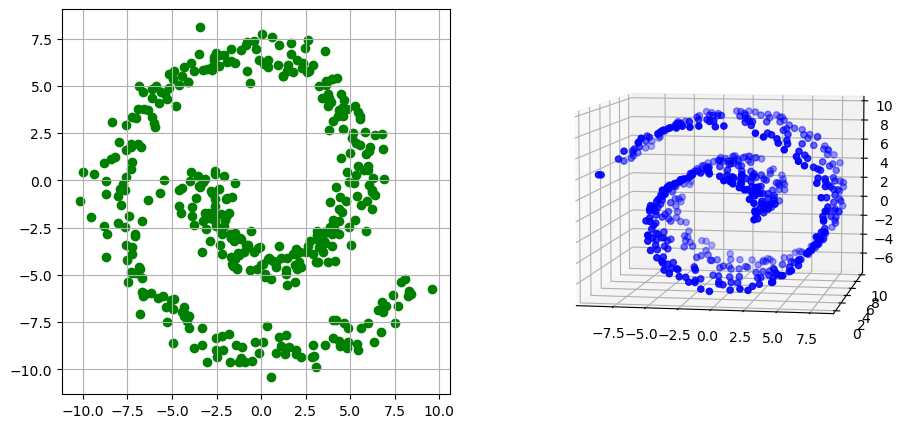

In [7]:
spiral = sample_spiral(
    n_spiral,
    min_radius,
    max_radius,
    key=subrngs[0],
    min_angle=min_angle + angle_shift,
    max_angle=max_angle + angle_shift,
    noise=noise,
)
swiss_roll = sample_swiss_roll(
    n_swiss_roll,
    min_radius,
    max_radius,
    key=subrngs[1:],
    length=length,
    min_angle=min_angle,
    max_angle=max_angle,
)

plot(swiss_roll, spiral, "blue", "green")

We define two {class}`point clouds <ott.geometry.pointcloud.PointCloud>` to describe each of these point clouds, each using (by default) the {class}`~ott.geometry.costs.SqEuclidean` cost function.

In [8]:
# Instantiate the Quadratic Alignment Problem
geom_xx = pointcloud.PointCloud(x=spiral, y=spiral)
geom_yy = pointcloud.PointCloud(x=swiss_roll, y=swiss_roll)
prob = quadratic_problem.QuadraticProblem(geom_xx, geom_yy)

# Instantiate a jitt'ed Gromov-Wasserstein solver
solver = jax.jit(
    gromov_wasserstein.GromovWasserstein(
        epsilon=100.0, max_iterations=20, store_inner_errors=True
    )
)
out = solver(prob)

has_converged = bool(out.linear_convergence[out.n_iters - 1])
print(f"{out.n_iters} outer iterations were needed.")
print(f"The last Sinkhorn iteration has converged: {has_converged}")
print(f"The outer loop of Gromov Wasserstein has converged: {out.converged}")
print(f"The final regularized GW cost is: {out.reg_gw_cost:.3f}")

5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 1183.616


The resulting transport matrix between the two point clouds is as follows:

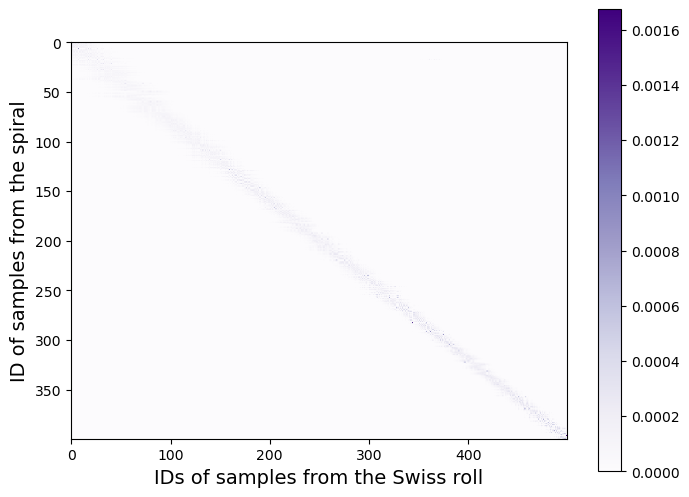

In [9]:
transport = out.matrix
fig = plt.figure(figsize=(8, 6))
plt.imshow(transport, cmap="Purples")
plt.xlabel(
    "IDs of samples from the Swiss roll", fontsize=14
)  # IDs are ordered from center to outer part
plt.ylabel(
    "ID of samples from the spiral", fontsize=14
)  # IDs are ordered from center to outer part
plt.colorbar()
plt.show()

The larger the regularization parameter `epsilon` is, the more diffuse the transport matrix becomes, as we can see in the animation below.

In [10]:
# Animates the transport matrix
fig = plt.figure(figsize=(8, 6))
im = plt.imshow(transport, cmap="Purples")
plt.xlabel(
    "IDs of samples from the Swiss roll", fontsize=14
)  # IDs are ordered from center to outer part
plt.ylabel(
    "IDs of samples from the spiral", fontsize=14
)  # IDs are ordered from center to outer part
plt.colorbar()


# Initialization function
def init():
    im.set_data(np.zeros(transport.shape))
    return [im]


# Animation function
def animate(i):
    array = im.get_array()
    geom_xx = pointcloud.PointCloud(x=spiral, y=spiral)
    geom_yy = pointcloud.PointCloud(x=swiss_roll, y=swiss_roll)
    prob = quadratic_problem.QuadraticProblem(geom_xx, geom_yy)

    solver = gromov_wasserstein.GromovWasserstein(epsilon=i, max_iterations=20)

    out = solver(prob)

    im.set_array(out.matrix)
    im.set_clim(0, jnp.max(out.matrix[:]))
    return [im]


# Call the animator
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=[70.0, 100.0, 200.0, 500.0, 750.0, 1000.0, 2000.0, 10000.0, 50000.0],
    interval=1500,
    blit=True,
)

html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()

To better understand the correspondence found by the {class}`~ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein` solver,
we plot in the same color, for each point in the spiral, the point in the Swiss roll it is the most coupled to.

In [11]:
# For each sample from the spiral, we get the most coupled point from the Swiss roll
indices_swiss_roll = jnp.array(np.argmax(transport, axis=1))

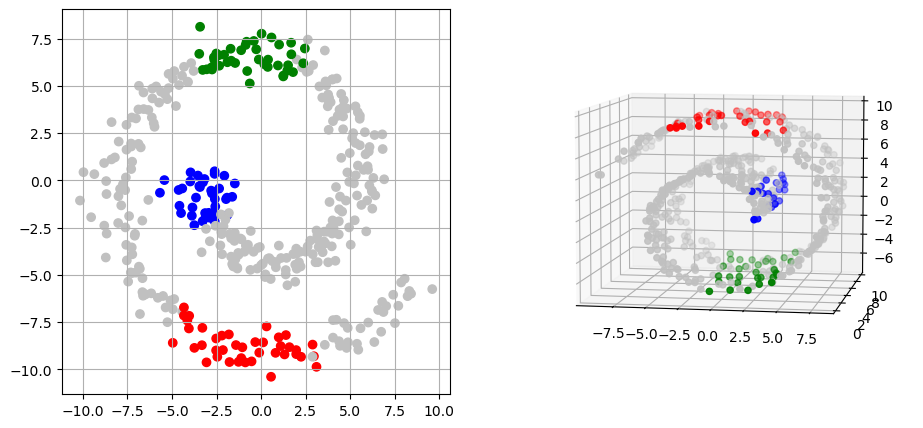

In [12]:
# Sets colors to visualise matching of some areas between each shape
# IDs of spiral and Swiss roll are ordered from center to outer part
colors_input_spiral = (
    ["b"] * 40
    + ["silver"] * 160
    + ["g"] * 40
    + ["silver"] * 90
    + ["r"] * 40
    + ["silver"] * 30
)
colors_swiss_roll = np.array(["silver"] * 500)
colors_swiss_roll[indices_swiss_roll[:40]] = "b"
colors_swiss_roll[indices_swiss_roll[200:240]] = "g"
colors_swiss_roll[indices_swiss_roll[330:370]] = "r"

plot(swiss_roll, spiral, colors_swiss_roll, colors_input_spiral)

## The Low Entropy Regime
What if we hope to find a more precise coupling?
Because the step size of the GW solver is inversely proportional to the regularization parameter, initializing near the optimum will increase our odds of convergence.
To help with that, we use the {class}`~ott.solvers.quadratic.lower_bound.LowerBoundSolver`, which implements the First Lower Bound from {cite}`memoli:11`.
The resulting coupling of this solver can then be used to initialize the Gromov Wasserstein solver or be used on its own.

In [13]:
from ott.solvers.quadratic import lower_bound, gromov_wasserstein_lr
from ott.initializers.quadratic import initializers

In [14]:
# Using a much smaller epsilon
epsilon = 0.02

# Instantiate a jitt'ed Gromov-Wasserstein solver
gw_solver = jax.jit(
    gromov_wasserstein.GromovWasserstein(
        epsilon=epsilon, store_inner_errors=True
    )
)

# Also jitt'ing the lower bound solver
lb_solver = jax.jit(
    lower_bound.LowerBoundSolver(epsilon, method="subsample")
)

# Need the lower bound value to initialize the last solver
lb_out = lb_solver(prob)

# Finally, jitt'ing Gromov-Wasserstein with lower bound initialization
lb_gw_solver = jax.jit(
    gromov_wasserstein.GromovWasserstein(
        epsilon=epsilon,
        store_inner_errors=True,
        quad_initializer=initializers.QuadraticInitializer(
            init_coupling=lb_out.matrix
        )
    )
)

# Warming up the solvers:
gw_out = gw_solver(prob)
lb_out = lb_solver(prob)
lb_gw_out = lb_gw_solver(prob)

In [15]:
print("Gromov Wasserstein (uniform initialization):")
%timeit gw_solver(prob)
print("Lower Bound:")
%timeit lb_solver(prob)
print("Gromov Wasserstein (lower bound initialization):")
%timeit lb_gw_solver(prob)

Gromov Wasserstein (uniform initialization):


1.4 s ± 786 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Lower Bound:
78 ms ± 48.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Gromov Wasserstein (lower bound initialization):
853 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


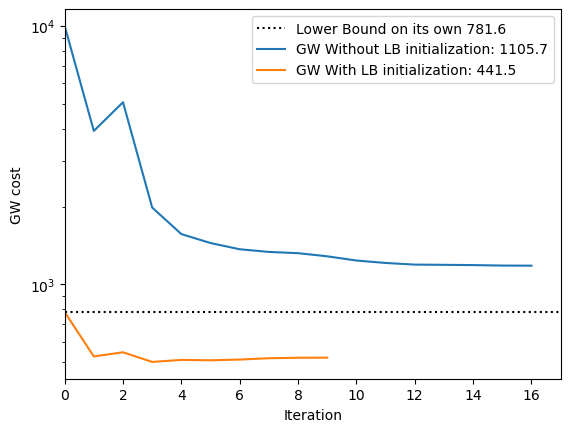

In [18]:
fig, ax = plt.subplots()

def plot_costs(output, ax, **kwargs):
    costs = output.costs
    n_iters = jnp.sum(output.costs != -1)
    ax.plot(costs[:n_iters], **kwargs)

ax.axhline(
    y = lb_gw_out.costs[0],
    label = f"Lower Bound on its own {lb_gw_out.costs[0]:.1f}",
    color='black',
    linestyle=":"
)
plot_costs(
    gw_out,
    ax=ax,
    label=f"GW Without LB initialization: {gw_out.primal_cost:.1f}"
)
plot_costs(
    lb_gw_out,
    ax=ax,
    label=f"GW With LB initialization: {lb_gw_out.primal_cost:.1f}"
)

ax.legend()
ax.set(
    yscale="log",
    ylabel="GW cost",
    xlabel="Iteration",
    xlim = (0, max([
        jnp.sum(lb_gw_out.costs != -1),
        jnp.sum(gw_out.costs != -1)
        ]))
)
plt.show()

Looks like using the Lower Bound alone might serve our purposes! It finds a better coupling than the uniformly initialized solver, at least. In the case where we really care about finding the optimal value, it looks like initializing the solver at the Lower Bound's coupling and then doing entropic Gromov-Wasserstein works well.

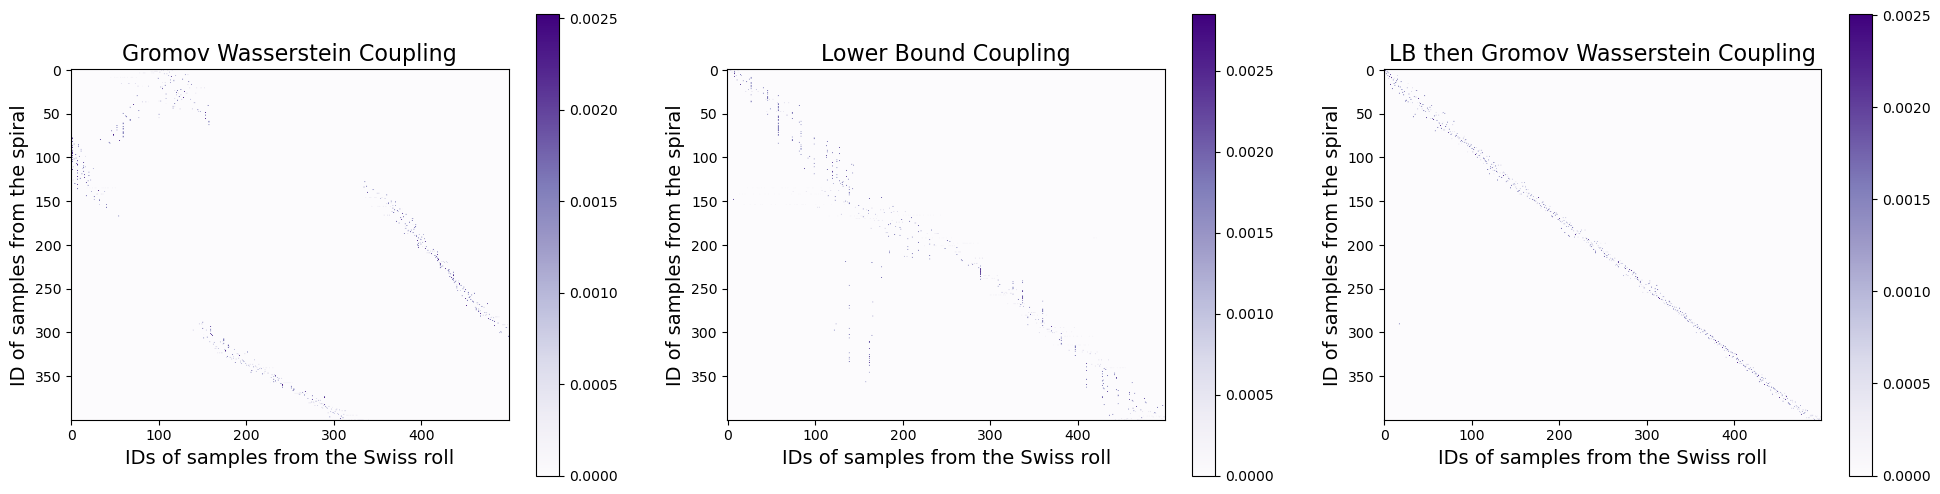

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

cax = axs[0].imshow(gw_out.matrix, cmap="Purples")
axs[0].set_xlabel(
    "IDs of samples from the Swiss roll", fontsize=14
)  # IDs are ordered from center to outer part
axs[0].set_ylabel(
    "ID of samples from the spiral", fontsize=14
)  # IDs are ordered from center to outer part
axs[0].set_title("Gromov Wasserstein Coupling", fontsize=16)
plt.colorbar(cax)

cax = axs[1].imshow(lb_out.matrix, cmap="Purples")
axs[1].set_xlabel(
    "IDs of samples from the Swiss roll", fontsize=14
)  # IDs are ordered from center to outer part
axs[1].set_ylabel(
    "ID of samples from the spiral", fontsize=14
)  # IDs are ordered from center to outer part
axs[1].set_title("Lower Bound Coupling", fontsize=16)
plt.colorbar(cax)

cax = axs[2].imshow(lb_gw_out.matrix, cmap="Purples")
axs[2].set_xlabel(
    "IDs of samples from the Swiss roll", fontsize=14
)  # IDs are ordered from center to outer part
axs[2].set_ylabel(
    "ID of samples from the spiral", fontsize=14
)  # IDs are ordered from center to outer part
axs[2].set_title("LB then Gromov Wasserstein Coupling", fontsize=16)
plt.colorbar(cax)

plt.show()

Here we can see that the Lower Bound doesn't find the best coupling, but does do a good job of approximating the optimal coupling.